# General Electric Customer Churn Problem
<br>
GE has partnered with a cellular carrier–SmartAppCellular–that provides dedicated bandwidth and configuration services for cell phone applications. GE is beginning to experience a small amount of attrition, and based on customer feedback, it is related to the cellular service and not the application. GE Healthcare recognizes that other vendors are beginning to compete in this space and is attempting to identify ways to retain its customers. <br><br>

The Customer Account Management team would like to determine if this data can be used to identify subscribers that may churn. It is important to be able to understand churn default drivers for metadata like longevity, cell usage, and other pertinent groupings which come from the analysis.<br>


-Genesis Taylor


### Import Modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
#import timeit
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

#stats
from scipy import stats
from scipy.stats import chi2_contingency

#sklearn modeling and metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection  import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

#warning ignorer
import warnings
warnings.filterwarnings("ignore")

#for imbalance
from imblearn.over_sampling import SMOTE
from collections import Counter


### Import and Explore Data Set

In [2]:
#import data set into datafream
df = pd.read_csv(r'DAT690_Churn Data_Training.csv')

In [3]:
#Get columns names and data shape and general look
print('Column Names:\n',df.columns)
print('\n')
print("Dataframe Shape:", df.shape)

df.head()

Column Names:
 Index(['REVENUE', 'MOU', 'RECCHRGE', 'DIRECTAS', 'OVERAGE', 'ROAM', 'CHANGEM',
       'CHANGER', 'DROPVCE', 'BLCKVCE', 'UNANSVCE', 'CUSTCARE', 'THREEWAY',
       'MOUREC', 'OUTCALLS', 'INCALLS', 'PEAKVCE', 'OPEAKVCE', 'DROPBLK',
       'CALLFWDV', 'CALLWAIT', 'CHURN', 'MONTHS', 'UNIQSUBS', 'ACTVSUBS',
       'CSA', 'PHONES', 'MODELS', 'EQPDAYS', 'CUSTOMER', 'AGE1', 'AGE2',
       'CHILDREN', 'CREDITA', 'CREDITAA', 'CREDITB', 'CREDITC', 'CREDITDE',
       'CREDITGY', 'CREDITZ', 'CREDIT_RATING', 'PRIZMRUR', 'PRIZMUB',
       'PRIZMTWN', 'Column 45', 'REFURB', 'WEBCAP', 'TRUCK', 'RV', 'OCCPROF',
       'OCCCLER', 'OCCCRFT', 'OCCSTUD', 'OCCHMKR', 'OCCRET', 'OCCSELF', 'OCC',
       'OCC_LABEL', 'OWNRENT', 'MARRYUN', 'MARRYYES', 'MARRYNO', 'MARRY',
       'MARRY_LABEL', 'MAILORD', 'MAILRES', 'MAILFLAG', 'TRAVEL', 'PCOWN',
       'CREDITCD', 'RETCALLS', 'RETACCPT', 'NEWCELLY', 'NEWCELLN', 'REFER',
       'INCMISS', 'INCOME', 'MCYCLE', 'CREDITAD', 'SETPRCM', 'SETPRC',
       'RE

,REVENUE,MOU,RECCHRGE,DIRECTAS,OVERAGE,ROAM,CHANGEM,CHANGER,DROPVCE,BLCKVCE,...,REFER,INCMISS,INCOME,MCYCLE,CREDITAD,SETPRCM,SETPRC,RETCALL,CALIBRAT,CHURNDEP
0,342.86,2961.25,139.96,11.14,1444.75,62.34,203.75,6.88,10.00,9.33,...,0,1,0,0,0,0,399.99,0,0,NaN
1,35.31,307.00,34.99,0.00,0.00,0.00,204.00,-0.32,1.00,2.33,...,0,0,6,0,1,0,29.99,0,0,NaN
2,84.66,1642.75,80.00,1.49,0.00,0.00,0.25,-2.47,9.33,9.00,...,0,1,0,0,0,0,29.99,0,0,NaN
3,65.62,321.50,50.00,0.25,2.25,0.00,-117.50,-13.63,12.67,2.67,...,0,0,7,0,0,0,99.99,0,0,NaN
4,86.48,807.00,75.00,0.00,0.00,0.26,110.00,-5.25,13.67,0.33,...,0,0,2,0,1,0,29.99,0,0,NaN


In [4]:
#data type count
df.dtypes.value_counts()

int64      56
float64    25
object      3
dtype: int64

In [5]:
#descriptive statistics about the data
df.describe()

,REVENUE,MOU,RECCHRGE,DIRECTAS,OVERAGE,ROAM,CHANGEM,CHANGER,DROPVCE,BLCKVCE,...,REFER,INCMISS,INCOME,MCYCLE,CREDITAD,SETPRCM,SETPRC,RETCALL,CALIBRAT,CHURNDEP
count,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,991.000000,991.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,563.000000
mean,59.662939,537.777503,47.186058,0.892106,41.523390,1.475938,-3.490585,-1.394097,6.131680,3.538140,...,0.059000,0.238000,4.369000,0.011000,0.057000,0.569000,36.935690,0.035000,0.563000,0.506217
std,48.110161,538.751303,24.436293,2.013783,109.214544,8.477650,254.537147,47.718943,9.044241,7.421263,...,0.354464,0.426072,3.112962,0.104355,0.337439,0.495464,58.053305,0.183872,0.496263,0.500406
min,4.840000,0.000000,0.000000,0.000000,0.000000,0.000000,-1345.500000,-341.800000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.900000,165.750000,30.000000,0.000000,0.000000,0.000000,-77.250000,-6.560000,0.670000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,47.240000,364.750000,44.990000,0.250000,1.750000,0.000000,-3.500000,-0.300000,3.000000,1.000000,...,0.000000,0.000000,5.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,70.500000,730.250000,59.990000,0.990000,36.500000,0.170000,62.875000,1.325000,8.000000,3.670000,...,0.000000,0.000000,7.000000,0.000000,0.000000,1.000000,59.990000,0.000000,1.000000,1.000000
max,526.560000,3656.250000,232.490000,22.770000,1444.750000,147.160000,1295.750000,895.570000,130.670000,77.000000,...,6.000000,1.000000,9.000000,1.000000,5.000000,1.000000,399.990000,1.000000,1.000000,1.000000


In [6]:
#unique values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df.nunique().sort_values(ascending=False))

CUSTOMER         1000
MOU               876
REVENUE           846
MOUREC            843
CHANGEM           768
CHANGER           722
EQPDAYS           583
PEAKVCE           497
OPEAKVCE          442
OVERAGE           339
CSA               277
UNANSVCE          264
OUTCALLS          258
RECCHRGE          244
ROAM              171
INCALLS           148
DROPBLK           137
DROPVCE            98
BLCKVCE            81
CALLWAIT           55
CUSTCARE           55
MONTHS             48
DIRECTAS           48
AGE1               37
AGE2               36
THREEWAY           24
PHONES             13
SETPRC             11
INCOME             10
OCC_LABEL           8
OCC                 8
MODELS              8
UNIQSUBS            7
CREDIT_RATING       7
REFER               7
ACTVSUBS            6
CREDITAD            6
Column 45           4
MARRY               3
CALLFWDV            3
RETACCPT            3
RETCALLS            3
CHILDREN            2
CREDITA             2
CHURN               2
CREDITB   

In [7]:
#Check Missing/null data
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df.isnull().sum().sort_values(ascending=False))

CHURNDEP         437
AGE2              14
AGE1              14
CHANGEM            9
CHANGER            9
MOU                3
RECCHRGE           3
DIRECTAS           3
OVERAGE            3
ROAM               3
REVENUE            3
NEWCELLY           0
CREDITB            0
CALLFWDV           0
CALLWAIT           0
CHURN              0
MONTHS             0
UNIQSUBS           0
ACTVSUBS           0
CSA                0
PHONES             0
MODELS             0
EQPDAYS            0
CUSTOMER           0
REFER              0
NEWCELLN           0
CHILDREN           0
CREDITA            0
DROPBLK            0
OPEAKVCE           0
PEAKVCE            0
INCMISS            0
RETCALL            0
SETPRC             0
SETPRCM            0
CREDITAD           0
MCYCLE             0
INCOME             0
DROPVCE            0
INCALLS            0
BLCKVCE            0
UNANSVCE           0
CUSTCARE           0
THREEWAY           0
MOUREC             0
OUTCALLS           0
CREDITAA           0
CREDITC      

In [8]:
#predicited variable
df['CHURN'].value_counts(ascending=True)

1    297
0    703
Name: CHURN, dtype: int64

### Data Cleansing

In [9]:
#standardize all columns to lowercase for ease of use in querying
df.columns = map(str.lower, df.columns)
#verify
print('Columns:\n',df.columns)

Columns:
 Index(['revenue', 'mou', 'recchrge', 'directas', 'overage', 'roam', 'changem',
       'changer', 'dropvce', 'blckvce', 'unansvce', 'custcare', 'threeway',
       'mourec', 'outcalls', 'incalls', 'peakvce', 'opeakvce', 'dropblk',
       'callfwdv', 'callwait', 'churn', 'months', 'uniqsubs', 'actvsubs',
       'csa', 'phones', 'models', 'eqpdays', 'customer', 'age1', 'age2',
       'children', 'credita', 'creditaa', 'creditb', 'creditc', 'creditde',
       'creditgy', 'creditz', 'credit_rating', 'prizmrur', 'prizmub',
       'prizmtwn', 'column 45', 'refurb', 'webcap', 'truck', 'rv', 'occprof',
       'occcler', 'occcrft', 'occstud', 'occhmkr', 'occret', 'occself', 'occ',
       'occ_label', 'ownrent', 'marryun', 'marryyes', 'marryno', 'marry',
       'marry_label', 'mailord', 'mailres', 'mailflag', 'travel', 'pcown',
       'creditcd', 'retcalls', 'retaccpt', 'newcelly', 'newcelln', 'refer',
       'incmiss', 'income', 'mcycle', 'creditad', 'setprcm', 'setprc',
       'retcall

In [10]:
#fixing mislabeled column according to data descriptipn file
df.rename(columns={'column 45':'przm_num'}, inplace=True)

#verify
print('Columns:\n',df.columns)

Columns:
 Index(['revenue', 'mou', 'recchrge', 'directas', 'overage', 'roam', 'changem',
       'changer', 'dropvce', 'blckvce', 'unansvce', 'custcare', 'threeway',
       'mourec', 'outcalls', 'incalls', 'peakvce', 'opeakvce', 'dropblk',
       'callfwdv', 'callwait', 'churn', 'months', 'uniqsubs', 'actvsubs',
       'csa', 'phones', 'models', 'eqpdays', 'customer', 'age1', 'age2',
       'children', 'credita', 'creditaa', 'creditb', 'creditc', 'creditde',
       'creditgy', 'creditz', 'credit_rating', 'prizmrur', 'prizmub',
       'prizmtwn', 'przm_num', 'refurb', 'webcap', 'truck', 'rv', 'occprof',
       'occcler', 'occcrft', 'occstud', 'occhmkr', 'occret', 'occself', 'occ',
       'occ_label', 'ownrent', 'marryun', 'marryyes', 'marryno', 'marry',
       'marry_label', 'mailord', 'mailres', 'mailflag', 'travel', 'pcown',
       'creditcd', 'retcalls', 'retaccpt', 'newcelly', 'newcelln', 'refer',
       'incmiss', 'income', 'mcycle', 'creditad', 'setprcm', 'setprc',
       'retcall'

In [11]:
#predicited variable
df['churn'].value_counts(ascending=True)

1    297
0    703
Name: churn, dtype: int64

In [12]:
#drop churndep because it is just a field set up for logreg
#drop calibrat bc I want to do my own separation
df = df.drop(['churndep'], axis=1)
df = df.drop(['calibrat'], axis=1)

### Changing Data Types

In [13]:
''' 
    Using data dictionary to fix some data types to string/objects. 
    So that they won't be misrepresented in any cleaning and calculations. 
    They're not actually numbers.
    This is mostly done for analysis purposes in Tableau.
    It is also done to properly handle null values.
    
'''

df['children'] = df['children'].apply(str)
df['churn'] = df['churn'].apply(str)
df['credit_rating'] = df['credit_rating'].apply(str)
df['credita'] = df['credita'].apply(str)
df['creditaa'] = df['creditaa'].apply(str)
df['creditad'] = df['creditad'].apply(str)
df['creditb'] = df['creditb'].apply(str)
df['creditc'] = df['creditc'].apply(str)
df['creditcd'] = df['creditcd'].apply(str)
df['creditde'] = df['creditde'].apply(str)
df['creditgy'] = df['creditgy'].apply(str)
df['creditz'] = df['creditz'].apply(str)
df['incmiss'] = df['incmiss'].apply(str)
df['income'] = df['income'].apply(str)
df['mailflag'] = df['mailflag'].apply(str)
df['mailord'] = df['mailord'].apply(str)
df['mailres'] = df['mailres'].apply(str)
df['marry'] = df['marry'].apply(str)
df['marryno'] = df['marryno'].apply(str)
df['marryun'] = df['marryun'].apply(str)
df['marryyes'] = df['marryyes'].apply(str)
df['mcycle'] = df['mcycle'].apply(str)
df['newcelln'] = df['newcelln'].apply(str)
df['newcelly'] = df['newcelly'].apply(str)
df['mailflag'] = df['mailflag'].apply(str)
df['mailord'] = df['mailord'].apply(str)
df['mailres'] = df['mailres'].apply(str)
df['marryno'] = df['marryno'].apply(str)
df['marryun'] = df['marryun'].apply(str)
df['marryyes'] = df['marryyes'].apply(str)
df['mcycle'] = df['mcycle'].apply(str)
df['newcelln'] = df['newcelln'].apply(str)
df['newcelly'] = df['newcelly'].apply(str)
df['occ'] = df['occ'].apply(str)
df['occ_label'] = df['occ_label'].apply(str)
df['occcler'] = df['occcler'].apply(str)
df['occcrft'] = df['occcrft'].apply(str)
df['occhmkr'] = df['occhmkr'].apply(str)
df['occprof'] = df['occprof'].apply(str)
df['occret'] = df['occret'].apply(str)
df['occself'] = df['occself'].apply(str)
df['occstud'] = df['occstud'].apply(str)
df['ownrent'] = df['ownrent'].apply(str)
df['pcown'] = df['pcown'].apply(str)
df['prizmrur'] = df['prizmrur'].apply(str)
df['prizmtwn'] = df['prizmtwn'].apply(str)
df['prizmub'] = df['prizmub'].apply(str)
df['przm_num'] = df['przm_num'].apply(str)
df['refurb'] = df['refurb'].apply(str)
df['retcall'] = df['retcall'].apply(str)
df['rv'] = df['rv'].apply(str)
df['setprcm'] = df['setprcm'].apply(str)
df['travel'] = df['travel'].apply(str)
df['truck'] = df['truck'].apply(str)
df['webcap'] = df['webcap'].apply(str)


In [14]:
#datatype count
df.dtypes.value_counts()

object     48
float64    24
int64      10
dtype: int64

### Missing Values

In [15]:
#Check Missing/null data
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df.isnull().sum().sort_values(ascending=False))

age2             14
age1             14
changem           9
changer           9
revenue           3
mou               3
recchrge          3
directas          3
overage           3
roam              3
csa               0
phones            0
models            0
eqpdays           0
customer          0
creditb           0
children          0
credita           0
creditaa          0
uniqsubs          0
creditc           0
creditde          0
creditgy          0
actvsubs          0
callfwdv          0
months            0
churn             0
callwait          0
setprc            0
dropblk           0
opeakvce          0
peakvce           0
incalls           0
outcalls          0
mourec            0
threeway          0
custcare          0
unansvce          0
blckvce           0
dropvce           0
creditz           0
retcall           0
prizmrur          0
prizmub           0
marry_label       0
mailord           0
mailres           0
mailflag          0
travel            0
pcown             0


#### Age1

In [16]:
#check values of age1

print("Age1 Values:")
print("Average Age1 w/o Zeroes: ", round(df['age1'].loc[df['age1']!=0].mean(),0))
print("Average Age1: ", round(df['age1'].mean(),0))
print("Minimum Age1 WITH Zeroes: ", df['age1'].min())
print("Minimum Age1 w/o Zeroes: ", df['age1'].loc[df['age1']!=0].min())
print("Maximum Age1: ", df['age1'].max())
print("Null values for Age1: ", pd.isnull(df['age1']).sum())

#check # 0s in age1
print("Number of Age1 Zeroes: ",(df['age1'] ==0).sum())

Age1 Values:
Average Age1 w/o Zeroes:  43.0
Average Age1:  31.0
Minimum Age1 WITH Zeroes:  0.0
Minimum Age1 w/o Zeroes:  18.0
Maximum Age1:  94.0
Null values for Age1:  14
Number of Age1 Zeroes:  266


In [17]:
''' Fill null age values to 0 to match the other ages that are missing AS 0.
    Will also create a "Missing" group for ages out of those groups later. '''

df['age1'].fillna(value=0, inplace=True)

In [18]:
#recheck values of age1

print("Age1 Values")
print("Average Age1: ", round(df['age1'].mean(),0))
print("Minimum Age1: ", df['age1'].min())
print("Maximum Age1: ", df['age1'].max())
print("Null values for Age1: ", pd.isnull(df['age1']).sum())
#check # 0s in age1
print("Number of Age1 Zeroes: ",(df['age1'] ==0).sum())

Age1 Values
Average Age1:  31.0
Minimum Age1:  0.0
Maximum Age1:  94.0
Null values for Age1:  0
Number of Age1 Zeroes:  280


#### Age2

In [19]:
#check values of age2

print("Age2 Values:")
print("Average Age2 w/o Zeroes: ", round(df['age2'].loc[df['age2']!=0].mean(),0))
print("Average Age2: ", round(df['age2'].mean(),0))
print("Minimum Age2 WITH Zeroes: ", df['age2'].min())
print("Minimum Age2 w/o Zeroes: ", df['age2'].loc[df['age2']!=0].min())
print("Maximum Age2: ", df['age2'].max())
print("Null values for Age2: ", pd.isnull(df['age2']).sum())

#check # 0s in age2
print("Number of Age2 Zeroes: ",(df['age2'] ==0).sum())

Age2 Values:
Average Age2 w/o Zeroes:  44.0
Average Age2:  21.0
Minimum Age2 WITH Zeroes:  0.0
Minimum Age2 w/o Zeroes:  18.0
Maximum Age2:  90.0
Null values for Age2:  14
Number of Age2 Zeroes:  521


In [20]:
''' Fill null age values to 0 to match the other ages that are missing As 0.
    Will also create a "Missing" group for ages out of those groups later. '''

df['age2'].fillna(value=0, inplace=True)

In [21]:
#recheck values of age2

print("Age2 Values")
print("Average Age2: ", round(df['age2'].mean(),0))
print("Minimum Age2: ", df['age2'].min())
print("Maximum Age2: ", df['age2'].max())
print("Null values for Age2: ", pd.isnull(df['age2']).sum())
#check # 0s in age2
print("Number of Age2 Zeroes: ",(df['age2'] ==0).sum())

Age2 Values
Average Age2:  21.0
Minimum Age2:  0.0
Maximum Age2:  90.0
Null values for Age2:  0
Number of Age2 Zeroes:  535


Because the values for the remaining null columns can legitimately have a zero value, and are numerical and discrete, I am going to fill the rest of those with their mean. I think that it is a safe choice being that the highest null is 9/1000.

In [22]:
'''
Because the values for the remaining null columns can legitimately have a zero value, 
and are numerical and discrete, I am going to fill the rest of those with their mean. 
I think that it is a safe choice being that the highest null is 9/1000.'''

#fill rest of nulls with their averages
df= df.fillna(df.mean())

In [23]:
#recheck nulls
df.isnull().sum().sort_values(ascending=False)

retcall      0
callwait     0
months       0
uniqsubs     0
actvsubs     0
            ..
occself      0
occ          0
occ_label    0
ownrent      0
revenue      0
Length: 82, dtype: int64

### Outliers

In [24]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df.describe(include='all'))

            revenue          mou     recchrge     directas      overage  \
count   1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
unique          NaN          NaN          NaN          NaN          NaN   
top             NaN          NaN          NaN          NaN          NaN   
freq            NaN          NaN          NaN          NaN          NaN   
mean      59.662939   537.777503    47.186058     0.892106    41.523390   
std       48.037869   537.941759    24.399574     2.010757   109.050435   
min        4.840000     0.000000     0.000000     0.000000     0.000000   
25%       32.930000   166.312500    30.000000     0.000000     0.000000   
50%       47.335000   366.000000    44.990000     0.250000     1.875000   
75%       70.110000   729.875000    59.990000     0.990000    37.000000   
max      526.560000  3656.250000   232.490000    22.770000  1444.750000   

               roam      changem      changer      dropvce      blckvce  \
count   1000.000000  100

In [25]:
#creating a backup dataframe before removing outliers using IQR
df3 = df

In [26]:
#outlier detection 
Q1 = df.quantile(0.05)
Q3 = df.quantile(0.95)
IQR = Q3 - Q1

In [27]:
#new dataframe with outliers removed
df=df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [28]:
#new dataframe shape
df.shape

(822, 82)

In [29]:
#predicited variable count
df['churn'].value_counts(ascending=True)

1    247
0    575
Name: churn, dtype: int64

### Grouping

#### age1

In [30]:
#value counts
df['age1'].value_counts(ascending=True)

90.0      1
18.0      1
74.0      1
88.0      1
86.0      1
78.0      2
20.0      2
80.0      3
76.0      3
64.0      4
70.0      5
66.0      5
72.0      6
62.0      6
22.0      7
68.0      7
60.0      9
24.0     19
56.0     22
26.0     22
50.0     23
58.0     24
48.0     25
30.0     27
54.0     29
38.0     31
32.0     31
44.0     32
36.0     33
34.0     34
52.0     35
28.0     36
42.0     36
40.0     37
46.0     40
0.0     222
Name: age1, dtype: int64

In [31]:
#Group the ages into groups
binsage=[0,17, 25, 35, 45, 55, 65, 99]
labelsage=['Missing','18-24','25-34','35-44','45-54', '55-64', '65+']
df['age_group'] = pd.cut(df['age1'], binsage, labels=labelsage, include_lowest=True)

In [32]:
#Age
print("Distinct values for age:\n", set(df['age_group']))

Distinct values for age:
 {'35-44', '45-54', '65+', 'Missing', '25-34', '55-64', '18-24'}


In [33]:
df['age_group'].value_counts(ascending=True)

18-24       29
65+         35
55-64       65
25-34      150
45-54      152
35-44      169
Missing    222
Name: age_group, dtype: int64

#### age2

In [34]:
#Group the ages for age2 into groups using same labels from age1
df['age_group2'] = pd.cut(df['age2'], binsage, labels=labelsage, include_lowest=True)

#Age
print("Distinct values for age:\n", set(df['age_group2']))
df['age_group2'].value_counts(ascending=True)

Distinct values for age:
 {'35-44', '45-54', '65+', 'Missing', '25-34', '55-64', '18-24'}


65+         28
18-24       30
55-64       44
25-34       77
35-44      101
45-54      106
Missing    436
Name: age_group2, dtype: int64

#### roam

In [35]:
print("roam Values")
print("Average roam: ", df['roam'].mean())
print("Minimum roam: ", df['roam'].min())
print("Maximum roam: ", df['roam'].max())
print("Null values: ", pd.isnull(df['roam']).sum())
print("Roam Value Counts:", df['roam'].value_counts(ascending=True))
#check # 0s in Roam
print("Number of Roam Zeroes: ",(df['roam'] ==0).sum())

roam Values
Average roam:  0.41072726695902795
Minimum roam:  0.0
Maximum roam:  10.54
Null values:  0
Roam Value Counts: 1.73       1
4.27       1
3.49       1
10.54      1
6.91       1
        ... 
0.32       8
0.20      15
0.16      17
0.10      21
0.00     593
Name: roam, Length: 126, dtype: int64
Number of Roam Zeroes:  593


In [36]:
#create groups for roaming
binsroam=[0,0.000000000001,1,2,3,4,5,6,7,8,9,10,11]
labelsroam=['Not_Roaming','1','2','3','4','5','6','7','8','9','10','over 10']
df['roaming_range'] = pd.cut(df['roam'], bins=binsroam, labels=labelsroam, include_lowest=True)

In [37]:
print("Distinct values for roam range:\n", set(df['roaming_range']))
print("Value counts for roaming range", df['roaming_range'].value_counts(ascending=True))

Distinct values for roam range:
 {'6', '7', 'Not_Roaming', '9', '4', '2', '5', 'over 10', '1', '3', '8'}
Value counts for roaming range 10               0
over 10          1
9                2
8                4
7                5
6                6
5                9
3               11
4               11
2               42
1              138
Not_Roaming    593
Name: roaming_range, dtype: int64


In [38]:
#Make sure the datatype for these new grouped columns are strings/objects
df['age_group'] = df['age_group'].astype(str)
df['age_group2'] = df['age_group2'].astype(str)
df['roaming_range'] = df['roaming_range'].astype(str)

df.dtypes

revenue          float64
mou              float64
recchrge         float64
directas         float64
overage          float64
                  ...   
setprc           float64
retcall           object
age_group         object
age_group2        object
roaming_range     object
Length: 85, dtype: object

In [39]:
#did they churn (this was done for visualization but not necessary)
df['churn_status'] = df.churn.replace(to_replace=[0,1], value=['no','yes'])

### Correlation and importance checks

In [40]:
#checking which columns are objects/strings
print("Object Columns:\n",list(df.select_dtypes(['object'])))

Object Columns:
 ['churn', 'csa', 'children', 'credita', 'creditaa', 'creditb', 'creditc', 'creditde', 'creditgy', 'creditz', 'credit_rating', 'prizmrur', 'prizmub', 'prizmtwn', 'przm_num', 'refurb', 'webcap', 'truck', 'rv', 'occprof', 'occcler', 'occcrft', 'occstud', 'occhmkr', 'occret', 'occself', 'occ', 'occ_label', 'ownrent', 'marryun', 'marryyes', 'marryno', 'marry', 'marry_label', 'mailord', 'mailres', 'mailflag', 'travel', 'pcown', 'creditcd', 'newcelly', 'newcelln', 'incmiss', 'income', 'mcycle', 'creditad', 'setprcm', 'retcall', 'age_group', 'age_group2', 'roaming_range', 'churn_status']


In [41]:
#checking which columns are floats
print("Float Columns:\n",list(df.select_dtypes(['float64'])))

Float Columns:
 ['revenue', 'mou', 'recchrge', 'directas', 'overage', 'roam', 'changem', 'changer', 'dropvce', 'blckvce', 'unansvce', 'custcare', 'threeway', 'mourec', 'outcalls', 'incalls', 'peakvce', 'opeakvce', 'dropblk', 'callfwdv', 'callwait', 'age1', 'age2', 'setprc']


In [42]:
#checking which columns are integers
print("Int Columns:\n",list(df.select_dtypes(['int64'])))

Int Columns:
 ['months', 'uniqsubs', 'actvsubs', 'phones', 'models', 'eqpdays', 'customer', 'retcalls', 'retaccpt', 'refer']


In [43]:
#separate the data into object vs nonobjects
notif=df.select_dtypes(exclude=['int','float','int64'])
intfldtypes = df.select_dtypes(include=['int','float','int64'])
print(df.shape)
print(notif.shape)
print(intfldtypes.shape)

(822, 86)
(822, 52)
(822, 34)


In [44]:
#label encode objects for correlaton/importance checking
obj_le= notif.apply(LabelEncoder().fit_transform)


#re-add with non-objects to df_ml
df_ml= pd.concat([obj_le,intfldtypes], axis=1, sort=False)
df_ml=df_ml.drop(['churn_status'], axis=1)


#check shape
print(df_ml.shape)

(822, 85)


#### Spearman's Correlation

In [45]:
#check correlation
#Spearman's correlation
print("Spearman's Correlation:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_ml.corr(method='spearman')['churn'].sort_values(ascending=False))
#corr[np.argsort(corr,axis=0)[::-1]]

Spearman's Correlation:
churn            1.000000
eqpdays          0.108040
refurb           0.100411
roam             0.081060
prizmub          0.056727
months           0.050740
setprcm          0.044384
uniqsubs         0.042080
creditc          0.041131
marry            0.034076
actvsubs         0.032985
marryun          0.031545
age_group        0.027069
prizmrur         0.024777
creditaa         0.024714
age_group2       0.022143
credita          0.016881
overage          0.015045
incmiss          0.011450
ownrent          0.010160
occ_label        0.009215
creditz          0.007538
income           0.007518
mailflag         0.005134
occstud          0.004336
csa              0.003830
occret           0.003692
age2             0.003310
occprof          0.001567
newcelln        -0.004534
pcown           -0.004606
przm_num        -0.005845
threeway        -0.007253
marryyes        -0.007435
creditb         -0.009634
creditad        -0.012910
occcrft         -0.014661
age1          

#### Kendall's Correlation

In [46]:
print("Kendall's Correlation")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_ml.corr(method ='kendall')['churn'].sort_values(ascending=False))

Kendall's Correlation
churn            1.000000
refurb           0.100411
eqpdays          0.088326
roam             0.075685
prizmub          0.056727
setprcm          0.044384
months           0.042228
creditc          0.041131
uniqsubs         0.040625
actvsubs         0.032551
marry            0.032169
marryun          0.031545
prizmrur         0.024777
creditaa         0.024714
age_group        0.024073
age_group2       0.020270
credita          0.016881
overage          0.013141
incmiss          0.011450
ownrent          0.010160
occ_label        0.008900
creditz          0.007538
income           0.006536
mailflag         0.005134
occstud          0.004336
occret           0.003692
csa              0.003142
age2             0.002960
occprof          0.001567
newcelln        -0.004534
pcown           -0.004606
przm_num        -0.005547
threeway        -0.006963
marryyes        -0.007435
creditb         -0.009634
creditad        -0.012863
occcrft         -0.014661
age1            

In [47]:
df_ml.columns

Index(['churn', 'csa', 'children', 'credita', 'creditaa', 'creditb', 'creditc',
       'creditde', 'creditgy', 'creditz', 'credit_rating', 'prizmrur',
       'prizmub', 'prizmtwn', 'przm_num', 'refurb', 'webcap', 'truck', 'rv',
       'occprof', 'occcler', 'occcrft', 'occstud', 'occhmkr', 'occret',
       'occself', 'occ', 'occ_label', 'ownrent', 'marryun', 'marryyes',
       'marryno', 'marry', 'marry_label', 'mailord', 'mailres', 'mailflag',
       'travel', 'pcown', 'creditcd', 'newcelly', 'newcelln', 'incmiss',
       'income', 'mcycle', 'creditad', 'setprcm', 'retcall', 'age_group',
       'age_group2', 'roaming_range', 'revenue', 'mou', 'recchrge', 'directas',
       'overage', 'roam', 'changem', 'changer', 'dropvce', 'blckvce',
       'unansvce', 'custcare', 'threeway', 'mourec', 'outcalls', 'incalls',
       'peakvce', 'opeakvce', 'dropblk', 'callfwdv', 'callwait', 'months',
       'uniqsubs', 'actvsubs', 'phones', 'models', 'eqpdays', 'customer',
       'age1', 'age2', 'retcal

#### Chi-Square for importance

In [48]:
class ChiSquare:
    def __init__(self, dataframe):
        self.df_ml = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.df_mlObserved = None
        self.df_mlExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="\n~~~~The column {0} is IMPORTANT for Prediction.~~~~\n".format(colX)
        else:
            result="The column {0} is NOT an important predictor.".format(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.10):
        X = self.df_ml[colX].astype(str)
        Y = self.df_ml[colY].astype(str)
        
        self.df_mlObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.df_mlObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.df_mlExpected = pd.DataFrame(expected, columns=self.df_mlObserved.columns, 
                                       index = self.df_mlObserved.index)
        
        self._print_chisquare_result(colX,alpha)

#Initialize ChiSquare Class
cT = ChiSquare(df_ml)

#Feature Selection
testColumns = ['age_group2','csa', 'occ_label', 'marry_label', 'age_group', 'roaming_range',
               'revenue', 'mou', 'recchrge', 'directas', 'overage', 'roam', 'changem',
               'changer', 'dropvce', 'blckvce', 'unansvce', 'custcare', 'threeway',
               'mourec', 'outcalls', 'incalls', 'peakvce', 'opeakvce', 'dropblk',
               'callfwdv', 'callwait', 'months', 'uniqsubs', 'actvsubs',
               'phones', 'models', 'eqpdays', 'customer', 'age1','age2', 'children',
               'credita', 'creditaa', 'creditb', 'creditc', 'creditde', 'creditgy',
               'creditz', 'credit_rating', 'prizmrur', 'prizmub', 'prizmtwn',
               'przm_num', 'refurb', 'webcap', 'truck', 'rv', 'occprof', 'occcler',
               'occcrft', 'occstud', 'occhmkr', 'occret', 'occself', 'occ', 'ownrent',
               'marryun', 'marryyes', 'marryno', 'marry', 'mailord', 'mailres',
               'mailflag', 'travel', 'pcown', 'creditcd', 'retcalls', 'retaccpt',
               'newcelly', 'newcelln', 'refer', 'incmiss', 'income', 'mcycle',
               'creditad', 'setprcm', 'setprc', 'retcall']
for var in testColumns:
    cT.TestIndependence(colX=var,colY="churn" )

The column age_group2 is NOT an important predictor.
The column csa is NOT an important predictor.
The column occ_label is NOT an important predictor.
The column marry_label is NOT an important predictor.
The column age_group is NOT an important predictor.
The column roaming_range is NOT an important predictor.
The column revenue is NOT an important predictor.
The column mou is NOT an important predictor.
The column recchrge is NOT an important predictor.
The column directas is NOT an important predictor.
The column overage is NOT an important predictor.
The column roam is NOT an important predictor.
The column changem is NOT an important predictor.
The column changer is NOT an important predictor.
The column dropvce is NOT an important predictor.
The column blckvce is NOT an important predictor.
The column unansvce is NOT an important predictor.
The column custcare is NOT an important predictor.
The column threeway is NOT an important predictor.
The column mourec is NOT an important p

In [49]:
df = df_ml

In [50]:
#new columns
"""
We will be making new columns out of the important columns from the Chi-Squared test above.

The important columns are as follows: 
                            months, creditgy, przm_num, refurb, webcap, mailord, and travel.

Some will be columns that I think would match well with the important column 
and others will be a combination of important columns. 

"""

#months
df['months_mou'] = df['months'].astype(str) + '_' + df['mou'].astype(str)
df['months_creditgy'] = df['months'].astype(str) + '_' + df['creditgy'].astype(str)
df['months_przm_num'] = df['months'].astype(str) + '_' + df['przm_num'].astype(str)
df['months_refurb'] = df['months'].astype(str) + '_' + df['refurb'].astype(str)
df['months_webcap'] = df['months'].astype(str) + '_' + df['webcap'].astype(str)
df['months_mailord'] = df['months'].astype(str) + '_' + df['mailord'].astype(str)
df['months_travel'] = df['months'].astype(str) + '_' + df['travel'].astype(str)
df['months_models'] = df['months'].astype(str) + '_' + df['models'].astype(str)
df['months_agegroup'] = df['months'].astype(str) + '_' + df['age_group'].astype(str)
df['months_agegroup2'] = df['months'].astype(str) + '_' + df['age_group2'].astype(str)

#creditgy
df['creditgy_przm_num'] = df['creditgy'].astype(str) + '_' + df['przm_num'].astype(str)
df['creditgy_refurb'] = df['creditgy'].astype(str) + '_' + df['refurb'].astype(str)
df['creditgy_webcap'] = df['creditgy'].astype(str) + '_' + df['webcap'].astype(str)
df['creditgy_mailord'] = df['creditgy'].astype(str) + '_' + df['mailord'].astype(str)
df['creditgy_travel'] = df['creditgy'].astype(str) + '_' + df['travel'].astype(str)
df['creditgy_income'] = df['creditgy'].astype(str) + '_' + df['income'].astype(str)
df['creditgy_agegroup'] = df['creditgy'].astype(str) + '_' + df['age_group'].astype(str)
df['creditgy_agegroup2'] = df['creditgy'].astype(str) + '_' + df['age_group2'].astype(str)
df['creditgy_occ'] = df['creditgy'].astype(str) + '_' + df['occ'].astype(str)

#przm_num
df['przm_num_refurb'] = df['przm_num'].astype(str) + '_' + df['refurb'].astype(str)
df['przm_num_webcap'] = df['przm_num'].astype(str) + '_' + df['webcap'].astype(str)
df['przm_num_mailord'] = df['przm_num'].astype(str) + '_' + df['mailord'].astype(str)
df['przm_num_travel'] = df['przm_num'].astype(str) + '_' + df['travel'].astype(str)
df['przm_num_dropblk'] = df['przm_num'].astype(str) + '_' + df['dropblk'].astype(str)
df['przm_num_dropvce'] = df['przm_num'].astype(str) + '_' + df['dropvce'].astype(str)
df['przm_num_roam_range'] = df['przm_num'].astype(str) + '_' + df['roaming_range'].astype(str)


#refurb
df['refurb_webcap'] = df['refurb'].astype(str) + '_' + df['webcap'].astype(str)
df['refurb_mailord'] = df['refurb'].astype(str) + '_' + df['mailord'].astype(str)
df['refurb_travel'] = df['refurb'].astype(str) + '_' + df['travel'].astype(str)
df['refurb_models'] = df['refurb'].astype(str) + '_' + df['models'].astype(str)
df['refurb_dropblk'] = df['refurb'].astype(str) + '_' + df['dropblk'].astype(str)
df['refurb_dropvce'] = df['refurb'].astype(str) + '_' + df['dropvce'].astype(str)
df['refurb_custcare'] = df['refurb'].astype(str) + '_' + df['custcare'].astype(str)
df['refurb_retcalls'] = df['refurb'].astype(str) + '_' + df['retcalls'].astype(str)
df['refurb_retcall'] = df['refurb'].astype(str) + '_' + df['retcall'].astype(str)

#webcap
df['webcap_mailord'] = df['webcap'].astype(str) + '_' + df['mailord'].astype(str)
df['webcap_travel'] = df['webcap'].astype(str) + '_' + df['travel'].astype(str)
df['webcap_agegroup'] = df['webcap'].astype(str) + '_' + df['age_group'].astype(str)
df['webcap_agegroup2'] = df['webcap'].astype(str) + '_' + df['age_group2'].astype(str)
df['webcap_income'] = df['webcap'].astype(str) + '_' + df['income'].astype(str)
df['webcap_setprc'] = df['webcap'].astype(str) + '_' + df['setprc'].astype(str)
df['webcap_retcall'] = df['webcap'].astype(str) + '_' + df['retcall'].astype(str)

#mailord
df['mailord_travel'] = df['mailord'].astype(str) + '_' + df['travel'].astype(str)
df['mailord_mailres'] = df['mailord'].astype(str) + '_' + df['mailres'].astype(str)
df['mailord_mailflag'] = df['mailord'].astype(str) + '_' + df['mailflag'].astype(str)
df['mailord_agegroup'] = df['mailord'].astype(str) + '_' + df['age_group'].astype(str)
df['mailord_agegroup2'] = df['mailord'].astype(str) + '_' + df['age_group2'].astype(str)

#travel
df['travel_roaming_range'] =df['travel'].astype(str) + '_' + df['roaming_range'].astype(str)
df['travel_income'] =df['travel'].astype(str) + '_' + df['income'].astype(str)
df['travel_occ'] =df['travel'].astype(str) + '_' + df['occ'].astype(str)
df['travel_marry'] =df['travel'].astype(str) + '_' + df['marry'].astype(str)


In [51]:
#re_separate the data into object vs nonobjects
notif2=df.select_dtypes(exclude=['int','float','int64'])
intfldtypes2 = df.select_dtypes(include=['int','float','int64'])
print(df.shape)
print(notif2.shape)
print(intfldtypes2.shape)

(822, 136)
(822, 51)
(822, 85)


In [52]:
#label encode objects
obj_le2= notif2.apply(LabelEncoder().fit_transform)
#re-add with non-objects
df_ml2= pd.concat([obj_le2,intfldtypes2], axis=1, sort=False)
#df_ml2=df_ml2.drop(['churn_status'], axis=1)
#check shape
print(df_ml2.shape)

(822, 136)


In [53]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
print(df_ml2.columns.tolist())

['months_mou', 'months_creditgy', 'months_przm_num', 'months_refurb', 'months_webcap', 'months_mailord', 'months_travel', 'months_models', 'months_agegroup', 'months_agegroup2', 'creditgy_przm_num', 'creditgy_refurb', 'creditgy_webcap', 'creditgy_mailord', 'creditgy_travel', 'creditgy_income', 'creditgy_agegroup', 'creditgy_agegroup2', 'creditgy_occ', 'przm_num_refurb', 'przm_num_webcap', 'przm_num_mailord', 'przm_num_travel', 'przm_num_dropblk', 'przm_num_dropvce', 'przm_num_roam_range', 'refurb_webcap', 'refurb_mailord', 'refurb_travel', 'refurb_models', 'refurb_dropblk', 'refurb_dropvce', 'refurb_custcare', 'refurb_retcalls', 'refurb_retcall', 'webcap_mailord', 'webcap_travel', 'webcap_agegroup', 'webcap_agegroup2', 'webcap_income', 'webcap_setprc', 'webcap_retcall', 'mailord_travel', 'mailord_mailres', 'mailord_mailflag', 'mailord_agegroup', 'mailord_agegroup2', 'travel_roaming_range', 'travel_income', 'travel_occ', 'travel_marry', 'churn', 'csa', 'children', 'credita', 'creditaa',

In [54]:
#chisquared #2 to check the importance with newly created columns added
class ChiSquare:
    def __init__(self, dataframe):
        self.df_ml2 = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.df_ml2Observed = None
        self.df_ml2Expected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="\n~~~~The column {0} is IMPORTANT for Prediction.~~~~\n".format(colX)
        else:
            result="The column {0} is NOT an important predictor.".format(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.10):
        X = self.df_ml2[colX].astype(str)
        Y = self.df_ml2[colY].astype(str)
        
        self.df_ml2Observed = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.df_ml2Observed.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.df_ml2Expected = pd.DataFrame(expected, columns=self.df_ml2Observed.columns, 
                                       index = self.df_ml2Observed.index)
        
        self._print_chisquare_result(colX,alpha)

#Initialize ChiSquare Class
cT = ChiSquare(df_ml2)

#Feature Selection
testColumns = ['months_mou', 'months_creditgy', 'months_przm_num', 'months_refurb', 'months_webcap', 
               'months_mailord', 'months_travel', 'months_models', 'months_agegroup', 
               'months_agegroup2', 'creditgy_przm_num', 'creditgy_refurb', 'creditgy_webcap', 
               'creditgy_mailord', 'creditgy_travel', 'creditgy_income', 'creditgy_agegroup', 
               'creditgy_agegroup2', 'creditgy_occ', 'przm_num_refurb', 'przm_num_webcap', 
               'przm_num_mailord', 'przm_num_travel', 'przm_num_dropblk', 'przm_num_dropvce', 
               'przm_num_roam_range', 'refurb_webcap', 'refurb_mailord', 'refurb_travel', 
               'refurb_models', 'refurb_dropblk', 'refurb_dropvce', 'refurb_custcare', 
               'refurb_retcalls', 'refurb_retcall', 'webcap_mailord', 'webcap_travel', 
               'webcap_agegroup', 'webcap_agegroup2', 'webcap_income', 'webcap_setprc', 
               'webcap_retcall', 'mailord_travel', 'mailord_mailres', 'mailord_mailflag', 
               'mailord_agegroup', 'mailord_agegroup2', 'travel_roaming_range', 'travel_income', 
               'travel_occ', 'travel_marry', 'csa', 'children', 'credita', 'creditaa', 'creditb', 
               'creditc', 'creditde', 'creditgy', 'creditz', 'credit_rating', 'prizmrur', 'prizmub', 
               'prizmtwn', 'przm_num', 'refurb', 'webcap', 'truck', 'rv', 'occprof', 'occcler', 
               'occcrft', 'occstud', 'occhmkr', 'occret', 'occself', 'occ', 'occ_label', 'ownrent', 
               'marryun', 'marryyes', 'marryno', 'marry', 'marry_label', 'mailord', 'mailres', 
               'mailflag', 'travel', 'pcown', 'creditcd', 'newcelly', 'newcelln', 'incmiss', 
               'income', 'mcycle', 'creditad', 'setprcm', 'retcall', 'age_group', 
               'age_group2', 'roaming_range', 'revenue', 'mou', 'recchrge', 'directas', 
               'overage', 'roam', 'changem', 'changer', 'dropvce', 'blckvce', 'unansvce', 
               'custcare', 'threeway', 'mourec', 'outcalls', 'incalls', 'peakvce', 'opeakvce', 
               'dropblk', 'callfwdv', 'callwait', 'months', 'uniqsubs', 'actvsubs', 'phones', 
               'models', 'eqpdays', 'customer', 'age1', 'age2', 'retcalls', 'retaccpt', 'refer', 
               'setprc']
for var in testColumns:
    cT.TestIndependence(colX=var,colY="churn" )

The column months_mou is NOT an important predictor.

~~~~The column months_creditgy is IMPORTANT for Prediction.~~~~


~~~~The column months_przm_num is IMPORTANT for Prediction.~~~~


~~~~The column months_refurb is IMPORTANT for Prediction.~~~~


~~~~The column months_webcap is IMPORTANT for Prediction.~~~~

The column months_mailord is NOT an important predictor.
The column months_travel is NOT an important predictor.

~~~~The column months_models is IMPORTANT for Prediction.~~~~

The column months_agegroup is NOT an important predictor.
The column months_agegroup2 is NOT an important predictor.

~~~~The column creditgy_przm_num is IMPORTANT for Prediction.~~~~


~~~~The column creditgy_refurb is IMPORTANT for Prediction.~~~~


~~~~The column creditgy_webcap is IMPORTANT for Prediction.~~~~


~~~~The column creditgy_mailord is IMPORTANT for Prediction.~~~~


~~~~The column creditgy_travel is IMPORTANT for Prediction.~~~~

The column creditgy_income is NOT an important predictor.
Th

In [55]:
#Creating a dataframe with important columns for visualizations later
df1 = df[['age_group', 'months_creditgy', 'months_przm_num', 'months_refurb', 'months_webcap', 
          'months_models', 'creditgy_przm_num', 'creditgy_refurb', 'creditgy_webcap', 
          'creditgy_mailord', 'creditgy_travel', 'przm_num_refurb', 'przm_num_webcap', 
          'przm_num_mailord', 'refurb_webcap', 'refurb_mailord', 'refurb_travel', 
          'refurb_models', 'refurb_retcalls', 'refurb_retcall', 'webcap_mailord', 
          'webcap_travel', 'webcap_setprc', 'webcap_retcall', 'mailord_mailres', 
          'creditgy', 'przm_num', 'refurb', 'webcap', 'mailord', 'travel', 
          'months','churn']]

In [56]:
#saving previously mentions dataframe to a csv for visualizations
df1.to_csv(r'celldata_to_visualize.csv', index=False)

### Model Preparation

In [57]:
#separate dtypes to do label encoding to actual df dataframe
notif=df.select_dtypes(exclude=['int','float','int64'])
intfldtypes = df.select_dtypes(include=['int','float','int64'])
print('Objects',notif.columns)
print("\nNonObjects",intfldtypes.columns)

#checking to make sure all are accounted for
print(df.shape)
print(notif.shape)
print(intfldtypes.shape)

Objects Index(['months_mou', 'months_creditgy', 'months_przm_num', 'months_refurb',
       'months_webcap', 'months_mailord', 'months_travel', 'months_models',
       'months_agegroup', 'months_agegroup2', 'creditgy_przm_num',
       'creditgy_refurb', 'creditgy_webcap', 'creditgy_mailord',
       'creditgy_travel', 'creditgy_income', 'creditgy_agegroup',
       'creditgy_agegroup2', 'creditgy_occ', 'przm_num_refurb',
       'przm_num_webcap', 'przm_num_mailord', 'przm_num_travel',
       'przm_num_dropblk', 'przm_num_dropvce', 'przm_num_roam_range',
       'refurb_webcap', 'refurb_mailord', 'refurb_travel', 'refurb_models',
       'refurb_dropblk', 'refurb_dropvce', 'refurb_custcare',
       'refurb_retcalls', 'refurb_retcall', 'webcap_mailord', 'webcap_travel',
       'webcap_agegroup', 'webcap_agegroup2', 'webcap_income', 'webcap_setprc',
       'webcap_retcall', 'mailord_travel', 'mailord_mailres',
       'mailord_mailflag', 'mailord_agegroup', 'mailord_agegroup2',
       'travel_r

In [58]:
#label encode objects
obj_le= notif.apply(LabelEncoder().fit_transform)

#re-add with non-objects
df_pred= pd.concat([obj_le,intfldtypes], axis=1, sort=False)
#check shape
print(df_pred.shape)

(822, 136)


#### Resampling imbalanced data

In [59]:
#set X and y for modeling
X=df_pred.drop(['churn'],axis=1)
y=df_pred['churn']

In [60]:
#checking value count of churn
df_pred.churn.value_counts()

0    575
1    247
Name: churn, dtype: int64

In [61]:
# SMOTE oversampling method from imblearn used to resample data
oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)


# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 575, 1: 575})


In [62]:
# setting up testing and training sets
res_X_train, res_X_test, res_y_train, res_y_test = train_test_split(X, y,
                                                                    test_size=0.25, random_state=42)

In [63]:
#scale X variable data
scaler = StandardScaler()

#fit training set
scaler.fit(res_X_train)

# Apply transform to both the training set and the test set
res_X_train = scaler.transform(res_X_train)
res_X_test = scaler.transform(res_X_test)





RandomForestClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 77.7778%
Cross validation scores: 0.7656642608928095
Log Loss: 0.48431632387361134


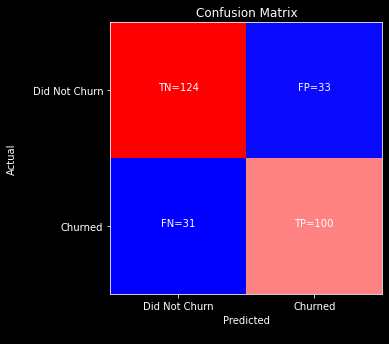





LogisticRegression Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 72.5694%
Cross validation scores: 0.742381716118685
Log Loss: 0.5025600393212577


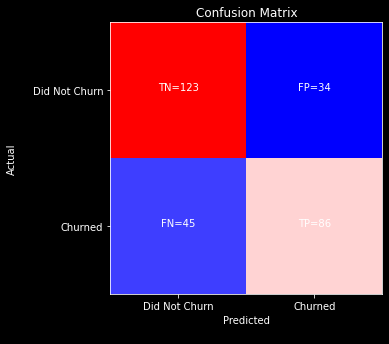

****************************************


In [64]:
#confusion matrix plot function
def cm_plot(var):
    plt.figure(figsize=(15,5))
    plt.clf()
    plt.imshow(var, interpolation='nearest', cmap='bwr')
    classNames = ['Did Not Churn','Churned']
    plt.title('Confusion Matrix')
    plt.ylabel('Actual\n')
    plt.xlabel('Predicted\n')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+"="+str(var[i][j]),horizontalalignment='center')
    plt.show()

#Modeling to compare Random Forest and Logistic Regression
classifiers = [
    RandomForestClassifier(random_state=42, n_estimators=100),
    LogisticRegression(random_state=42)]

#putting performance measure results in df
res_cols=["Classifier", "Accuracy", "Log Loss", "Cross Val", "Recall", "Roc Auc","F1", 
          "False Positive Rate", "Error Rate"]
results = pd.DataFrame(columns=res_cols)

#measure specifications
for clf in classifiers:
    clf.fit(res_X_train, res_y_train)
    name = clf.__class__.__name__
    
    print("\n"*3)
    print(name,"Results:")
       
    print('~'*40)
    res_y_pred = clf.predict(res_X_test)
    acc = accuracy_score(res_y_test, res_y_pred)
    print("Accuracy: {:.4%}".format(acc))
    
    cv= np.mean(cross_val_score(clf, res_X_train, res_y_train, cv=10))
    print("Cross validation scores:",cv)
    
    
    train_predictions = clf.predict_proba(res_X_test)
    logloss = log_loss(res_y_test, train_predictions)
    print("Log Loss: {}".format(logloss))
    
    cm = confusion_matrix(res_y_test, res_y_pred)
    
    cm_plot(cm)
    
    #FPR and Error Rate setup
    tn, fp, fn, tp = confusion_matrix(res_y_test,res_y_pred).ravel()
    
    fpr = fp/(tn+fp)
    ers = 1-acc
    rec= recall_score(res_y_test, res_y_pred)
    roc=roc_auc_score(res_y_test, res_y_pred, average='weighted')
    f1s=f1_score(res_y_test, res_y_pred, average='weighted')
    results_final = pd.DataFrame([[name, round(acc*100,3), round(logloss,3), 
                                   round(cv*100,3), round(rec*100,3), round(roc*100,3),
                                   round(f1s*100,3),round(fpr*100,3),round(ers*100,3)]],
                                 columns=res_cols)
    results = results.append(results_final)
    
print("*"*40)

In [65]:
#checking scores of rf and lr
print("Shape",results.shape)
results.head(10)

Shape (2, 9)


,Classifier,Accuracy,Log Loss,Cross Val,Recall,Roc Auc,F1,False Positive Rate,Error Rate
0,RandomForestClassifier,77.778,0.484,76.566,76.336,77.658,77.791,21.019,22.222
0,LogisticRegression,72.569,0.503,74.238,65.649,71.996,72.433,21.656,27.431


In [ ]:
'''AFTER EVALUATING THE ALGORITHMS AND THEIR PERFORMANCE 
RANDOM FOREST PERFORMED THE BEST SO PARAMETER TUNING WILL BE DONE TO IT
FOR THE BEST SET OF PARAMETERS'''

#not necessary to re-run unless you want to parameter tune again (timely)

#Get tuning parameter of  random forest
#random forest

# timing to see how long it takes

#start
tune_start_rfc = time.time()
rfc = RandomForestClassifier()
print('\n')
param_grid = {
    'bootstrap': [True, False],
    'n_estimators': [400, 1000],
    'criterion': ['entropy','gini'],
    'max_depth': [100,150],
    'min_samples_split': [0, 2, 4],   
    'max_features': ['auto', 2, 3],
    'n_jobs':[None, 2],
    'warm_start': [True],
    'random_state':[42]}



grid_rfc = GridSearchCV(rfc, param_grid = param_grid, scoring='accuracy', cv = 10)
grid_rfc.fit(res_X_train,res_y_train)
rfcbest_estimator = grid_rfc.best_estimator_
print("Random Forest:\n",grid_rfc.best_params_)
print('\n')
tune_end_rfc = time.time()
print("\nTuning Random Forest Time (in minutes): ", (tune_end_rfc - tune_start_rfc)/60)






RandomForestClassifier results2:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 79.1667%
Cross validation scores: 0.7667602245388934
Log Loss: 0.46563905510980913


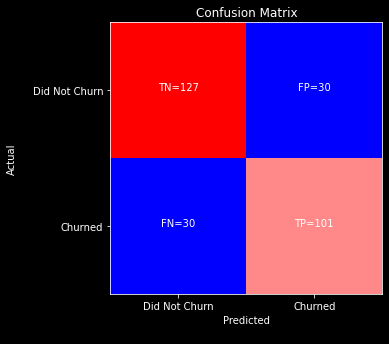

****************************************


In [66]:
#Final Random Forest Modelling
classifiers = [
    RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=100, 
                           min_samples_split=2, n_estimators=1000, max_features=3, 
                           class_weight='balanced', warm_start=True, n_jobs=None, 
                           random_state=42)]

#putting results2 in df
res_cols=["Classifier", "Accuracy", "Log Loss", "Cross Val", "Recall", "Roc Auc","F1", 
          "False Positive Rate", "Error Rate"]
results2 = pd.DataFrame(columns=res_cols)

for clf in classifiers:
    clf.fit(res_X_train, res_y_train)
    name = clf.__class__.__name__
    
    print("\n"*3)
    print(name,"results2:")
       
    print('~'*40)
    res_y_pred = clf.predict(res_X_test)
    acc = accuracy_score(res_y_test, res_y_pred)
    print("Accuracy: {:.4%}".format(acc))
    
    cv= np.mean(cross_val_score(clf, res_X_train, res_y_train, cv=10))
    print("Cross validation scores:",cv)
    
    
    train_predictions = clf.predict_proba(res_X_test)
    logloss = log_loss(res_y_test, train_predictions)
    print("Log Loss: {}".format(logloss))
    
    cm = confusion_matrix(res_y_test, res_y_pred)
    
    cm_plot(cm)
    
    #FPR and Error Rate setup
    tn, fp, fn, tp = confusion_matrix(res_y_test,res_y_pred).ravel()
    
    fpr = fp/(tn+fp)
    ers = 1-acc
    rec= recall_score(res_y_test, res_y_pred)
    roc=roc_auc_score(res_y_test, res_y_pred, average='weighted')
    f1s=f1_score(res_y_test, res_y_pred, average='weighted')
    results2_final = pd.DataFrame([[name, round(acc*100,3), round(logloss,3), 
                                   round(cv*100,3), round(rec*100,3), round(roc*100,3),
                                   round(f1s*100,3),round(fpr*100,3),round(ers*100,3)]],
                                 columns=res_cols)
    results2 = results2.append(results2_final)
    
print("*"*40)

In [ ]:
#checking feature importance just in case
start_time = time.time()

importances = clf.feature_importances_

feature_names = X.columns

forest_importances = pd.Series(importances, index=feature_names)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(forest_importances.sort_values(ascending=False))

In [67]:
results2['Classifier'] = results2['Classifier'].replace(['RandomForestClassifier'],
                                                        'RetunedRandomForestClassifier')
results2.head()

,Classifier,Accuracy,Log Loss,Cross Val,Recall,Roc Auc,F1,False Positive Rate,Error Rate
0,RetunedRandomForestClassifier,79.167,0.466,76.676,77.099,78.995,79.167,19.108,20.833


In [68]:
ml_results = pd.concat([results,results2])
ml_results.reset_index(drop=True, inplace=True)
print("Shape",ml_results.shape)
ml_results.head(10)

Shape (3, 9)


,Classifier,Accuracy,Log Loss,Cross Val,Recall,Roc Auc,F1,False Positive Rate,Error Rate
0,RandomForestClassifier,77.778,0.484,76.566,76.336,77.658,77.791,21.019,22.222
1,LogisticRegression,72.569,0.503,74.238,65.649,71.996,72.433,21.656,27.431
2,RetunedRandomForestClassifier,79.167,0.466,76.676,77.099,78.995,79.167,19.108,20.833


In [69]:
'''
    testing model on another set of data
    importing cleaned dataset (verificationdataset.csv) from another notebook to be tested.'''

#import data set into datafream
ver_df= pd.read_csv(r'verificationdataset.csv')

#Create X an y test sets
ver_X_test = ver_df.drop(['churn'],axis=1)
ver_y_test = ver_df['churn']


In [70]:
#scale verification X set
ver_X_test = scaler.transform(ver_X_test)





RandomForestClassifier results3:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 90.2985%
Cross validation scores: 0.7667602245388934
Log Loss: 0.42397438171986906


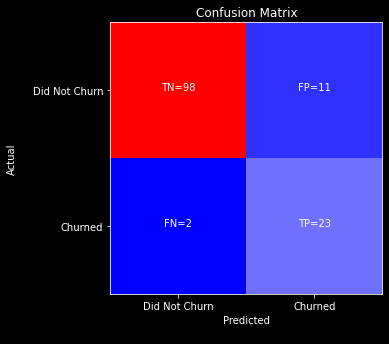

****************************************


In [71]:
#Final Random Forest Modelling
classifiers = [
    RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=100, 
                           min_samples_split=2, n_estimators=1000, max_features=3, 
                           class_weight='balanced', warm_start=True, n_jobs=None, 
                           random_state=42)]

#putting results3 in df
res_cols=["Classifier", "Accuracy", "Log Loss", "Cross Val", "Recall", "Roc Auc","F1", 
          "False Positive Rate", "Error Rate"]
results3 = pd.DataFrame(columns=res_cols)

for clf in classifiers:
    clf.fit(res_X_train, res_y_train)
    name = clf.__class__.__name__
    
    print("\n"*3)
    print(name,"results3:")
       
    print('~'*40)
    ver_y_pred = clf.predict(ver_X_test)
    acc = accuracy_score(ver_y_test, ver_y_pred)
    print("Accuracy: {:.4%}".format(acc))
    
    cv= np.mean(cross_val_score(clf, res_X_train, res_y_train, cv=10))
    print("Cross validation scores:",cv)
    
    
    train_predictions = clf.predict_proba(ver_X_test)
    logloss = log_loss(ver_y_test, train_predictions)
    print("Log Loss: {}".format(logloss))
    
    cm = confusion_matrix(ver_y_test, ver_y_pred)
    
    cm_plot(cm)
    
    #FPR and Error Rate setup
    tn, fp, fn, tp = confusion_matrix(ver_y_test,ver_y_pred).ravel()
    
    fpr = fp/(tn+fp)
    ers = 1-acc
    rec= recall_score(ver_y_test, ver_y_pred)
    roc=roc_auc_score(ver_y_test, ver_y_pred, average='weighted')
    f1s=f1_score(ver_y_test, ver_y_pred, average='weighted')
    results3_final = pd.DataFrame([[name, round(acc*100,3), round(logloss,3), 
                                   round(cv*100,3), round(rec*100,3), round(roc*100,3),
                                   round(f1s*100,3),round(fpr*100,3),round(ers*100,3)]],
                                 columns=res_cols)
    results3 = results3.append(results3_final)
    
print("*"*40)

In [72]:
results3['Classifier'] = results3['Classifier'].replace(['RandomForestClassifier'],
                                                        'VerificationRandomForestClassifier')
results3.head()

,Classifier,Accuracy,Log Loss,Cross Val,Recall,Roc Auc,F1,False Positive Rate,Error Rate
0,VerificationRandomForestClassifier,90.299,0.424,76.676,92.0,90.954,90.83,10.092,9.701


In [73]:
ml_results = pd.concat([results,results2,results3])
ml_results.reset_index(drop=True, inplace=True)
print("Shape",ml_results.shape)
ml_results.head(10)

Shape (4, 9)


,Classifier,Accuracy,Log Loss,Cross Val,Recall,Roc Auc,F1,False Positive Rate,Error Rate
0,RandomForestClassifier,77.778,0.484,76.566,76.336,77.658,77.791,21.019,22.222
1,LogisticRegression,72.569,0.503,74.238,65.649,71.996,72.433,21.656,27.431
2,RetunedRandomForestClassifier,79.167,0.466,76.676,77.099,78.995,79.167,19.108,20.833
3,VerificationRandomForestClassifier,90.299,0.424,76.676,92.000,90.954,90.830,10.092,9.701


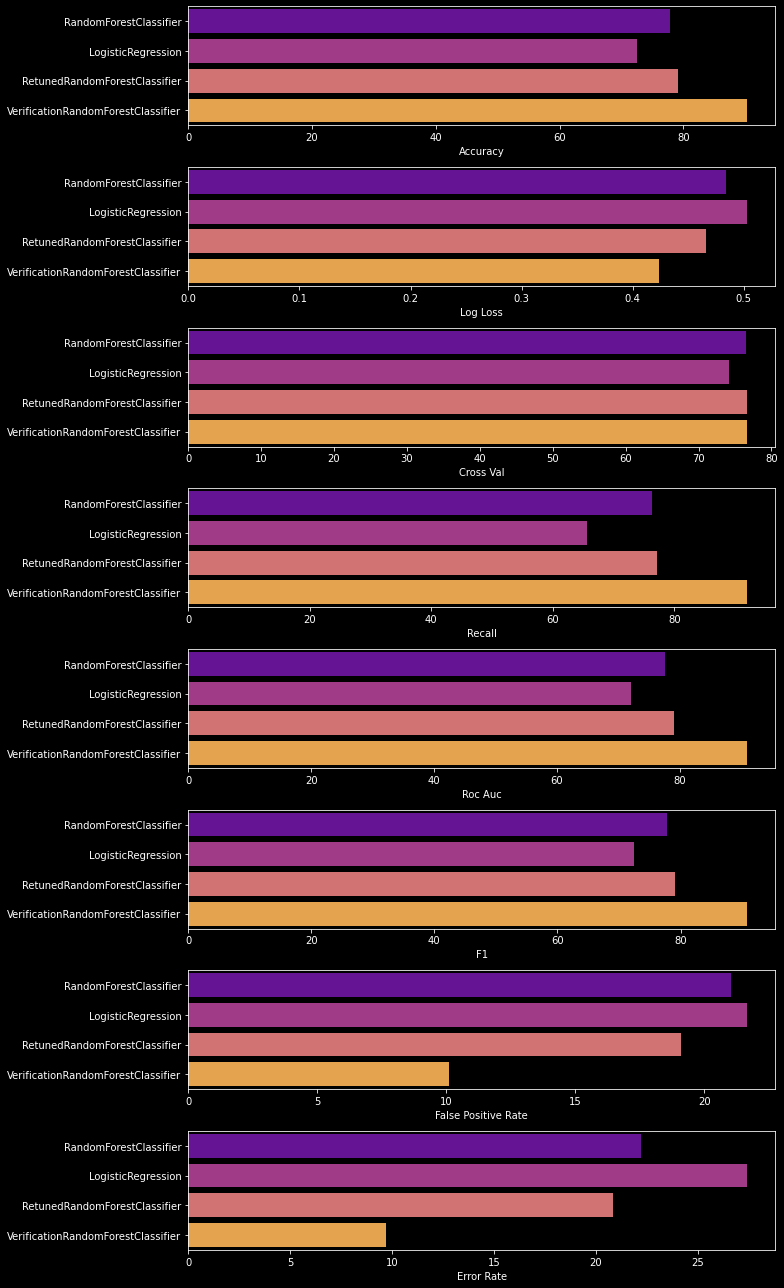

In [74]:
#Visualize scores for all models

fig, ax =plt.subplots(nrows=8, ncols=1, figsize = (11,18))

sns.barplot(x='Accuracy', y='Classifier', data=ml_results, palette='plasma', ax=ax[0])
sns.barplot(x='Log Loss', y='Classifier', data=ml_results, palette='plasma', ax=ax[1])
sns.barplot(x='Cross Val', y='Classifier', data=ml_results, palette='plasma', ax=ax[2])
sns.barplot(x='Recall', y='Classifier', data=ml_results, palette='plasma', ax=ax[3])
sns.barplot(x='Roc Auc', y='Classifier', data=ml_results, palette='plasma', ax=ax[4])
sns.barplot(x='F1', y='Classifier', data=ml_results, palette='plasma', ax=ax[5])
sns.barplot(x='False Positive Rate', y='Classifier', data=ml_results, palette='plasma', ax=ax[6])
sns.barplot(x='Error Rate', y='Classifier', data=ml_results, palette='plasma', ax=ax[7])

#remove classifier label from y
ax[0].set(ylabel = '')
ax[1].set(ylabel = '')
ax[2].set(ylabel = '')
ax[3].set(ylabel = '')
ax[4].set(ylabel = '')
ax[5].set(ylabel = '')
ax[6].set(ylabel = '')
ax[7].set(ylabel = '')

plt.tight_layout()
plt.savefig('machinelearningresults.png')
plt.show()

In [75]:
ml_results.to_csv(r'ml_results.csv', index=False)